## TODO on Hierarchical Inference

1) Explore how to fix regions with probability -np.inf to change them to regions with very small probability that still give direction to the sampler (i.e. keep the shape of the distribution but scaled by a very small number)

2) See if you can profile the sampler to accelerate its sampling

3) Decide on a specific method for dealing with outlier samples in the interim prior. It's currently hard coded to set them to the boundary, but this will bias inference

4) Tests, tests, tests. We need to test everything

5) Update things to agree with what Ji Won updates in baobab

6) Test/write the new exponential suppression function

7) Provide a method by which none of the initialization points give -np.inf

In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import model_trainer, hierarchical_inference
from multiprocessing import Pool

In [2]:
# First specify the config path
root_path = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/'
config_path = root_path + 'configs/nn1.json'

# We also need the path to the baobab configs for the interim and target omega
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/test_baobab_cfg_prior.py'

test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/datasets/cent_narrow/'
test_dataset_rf_record_path = test_dataset_path + 'tf_dataset'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# Correct any path issues.
def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(cfg)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
hier_infer = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_baobab_omega_path,
                                                      test_dataset_path,test_dataset_rf_record_path)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 100 is a good starting point though.
num_samples = 200
hier_infer.gen_samples(num_samples)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/models/nn1.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Rotations/Phil/ovejero/datasets/cent_narrow/tf_dataset


100%|██████████| 200/200 [14:51<00:00,  4.41s/it]


In [55]:
n_walkers = 50
save_path = 'chains3.h5'
hier_infer.initialize_sampler(n_walkers,save_path,None)
# curr_state = hier_infer.sampler.chain[:,-1,:]
# hier_infer.cur_state = curr_state

No chains found at chains3.h5


In [128]:
# cur_state = hier_infer.sampler.chain[:,-100]
# for i in range(50):
#     hyp_test = cur_state[i]
#     if hier_infer.log_post_omega(hyp_test) == -np.inf:
#         print(i)
#         cur_state[i] = cur_state[np.random.randint(len(cur_state))]+np.random.rand(len(cur_state[0]))*0.01
hier_infer.cur_state=cur_state

In [153]:
# %%prun -s cumulative
n_samps = 100
hier_infer.run_samples(n_samps)

In [154]:
hyperparam_plot_names = [r'$\mu_{\gamma_\mathrm{ext}}$',r'$\sigma_{\gamma_\mathrm{ext}}$',
                         r'$\mu_\psi$',r'$\alpha_\psi$',r'$p_\psi$',r'$\mathrm{lower}_\psi$',
                         r'$\mathrm{upper}_\psi$',r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$a_{e1}$',r'$b_{e1}$',r'$\mathrm{lower}_{e1}$',r'$\mathrm{upper}_{e1}$',
                         r'$a_{e2}$',r'$b_{e2}$',r'$\mathrm{lower}_{e2}$',r'$\mathrm{upper}_{e2}$',
                         r'$\mu_{\gamma_\mathrm{lens}}$',r'$\sigma_{\gamma_\mathrm{lens}}$',
                         r'$\mu_{\theta_E}$',r'$\sigma_{\theta_E}$']

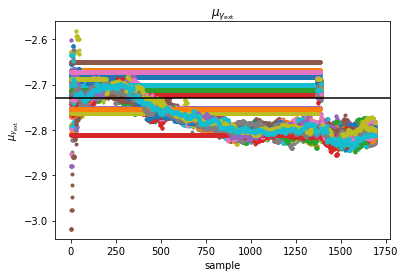

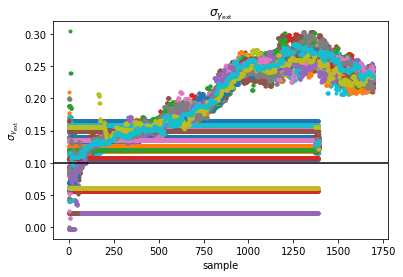

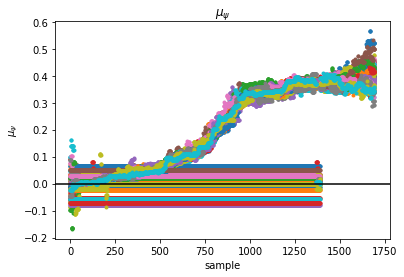

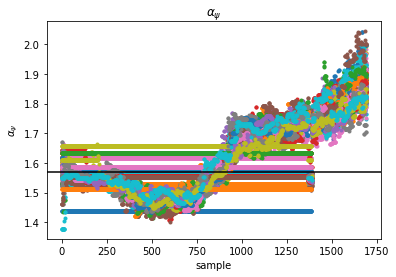

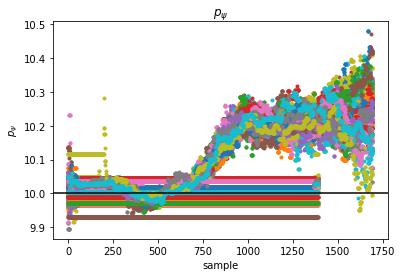

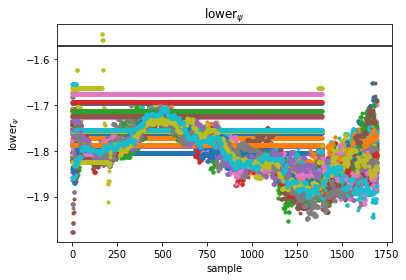

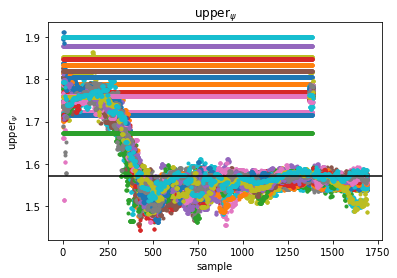

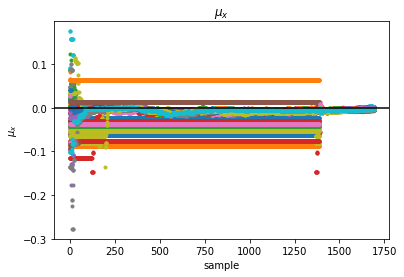

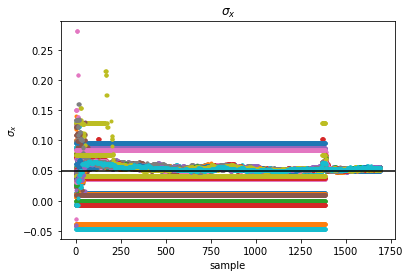

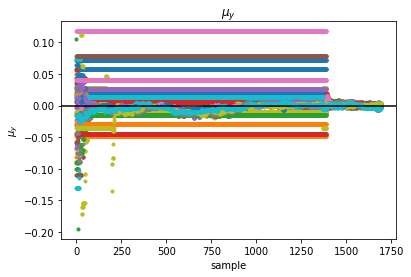

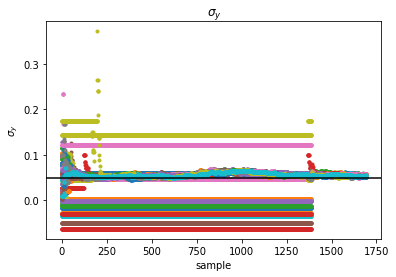

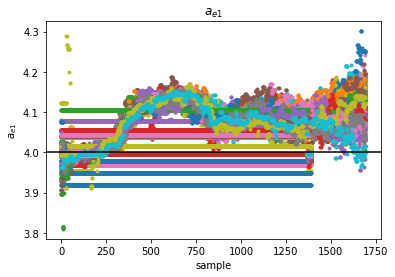

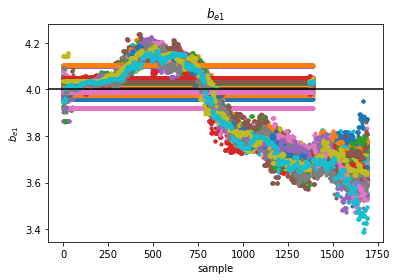

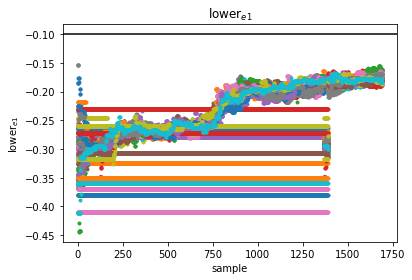

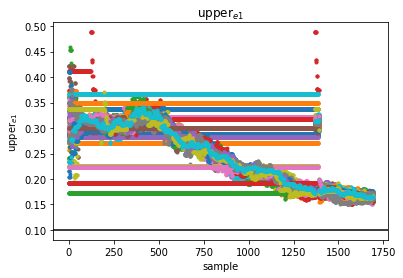

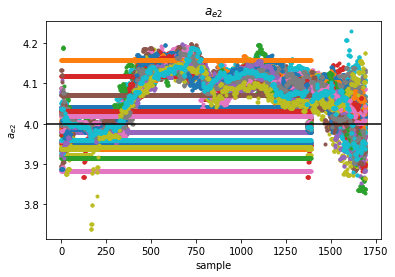

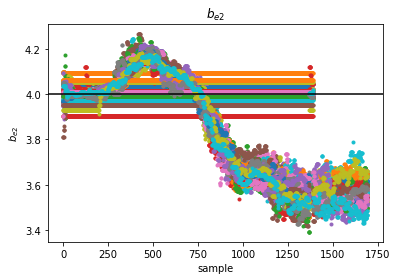

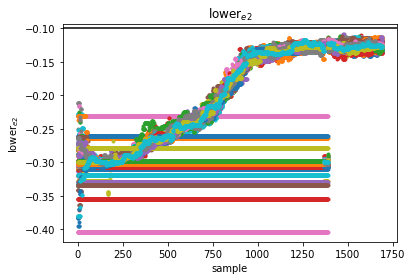

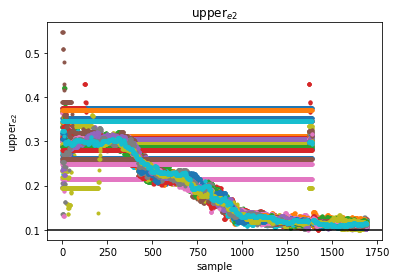

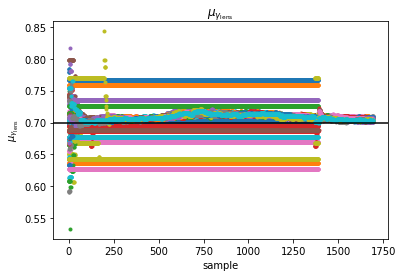

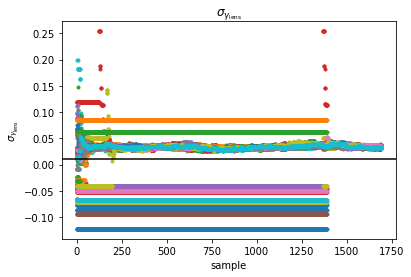

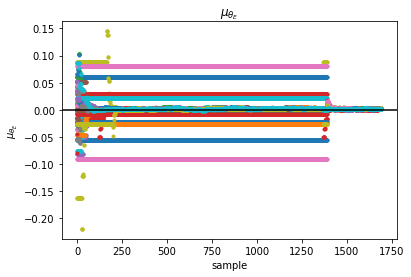

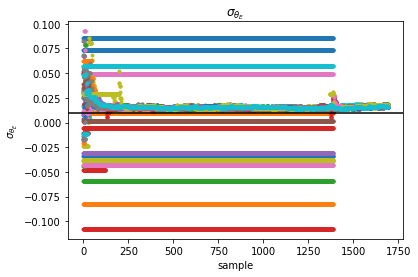

In [155]:
hier_infer.plot_chains(burnin=None,hyperparam_plot_names=hyperparam_plot_names)

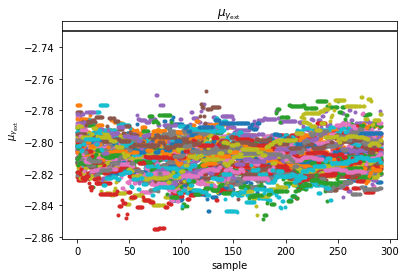

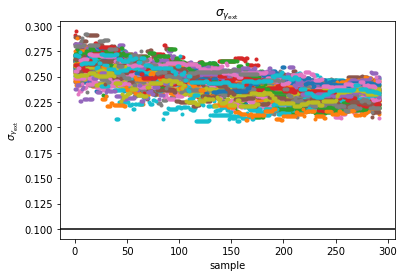

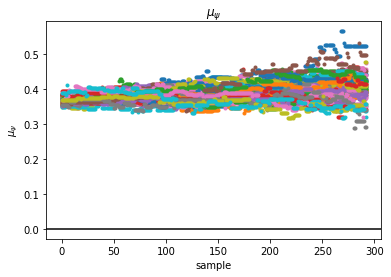

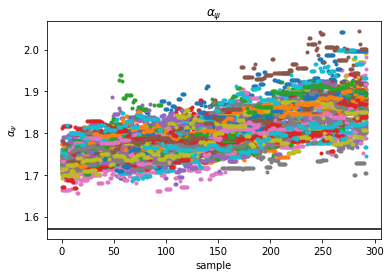

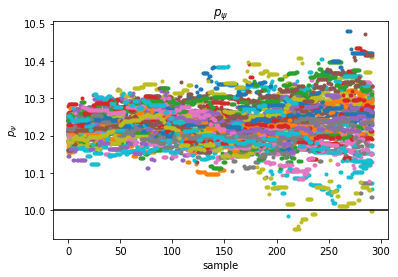

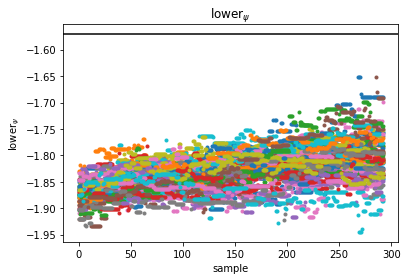

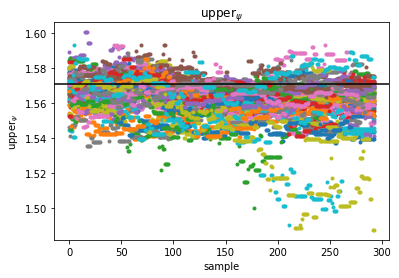

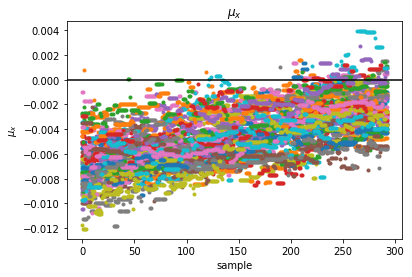

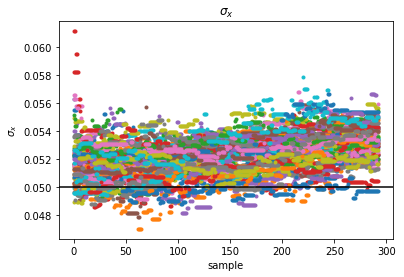

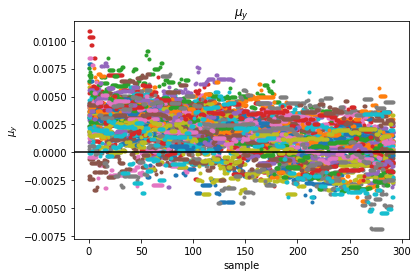

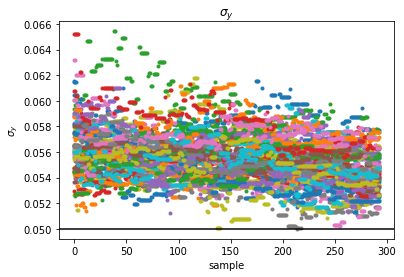

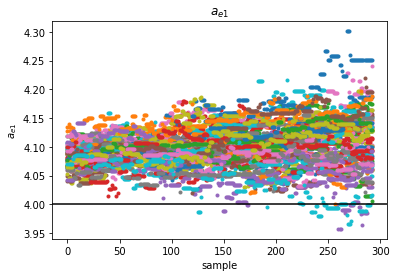

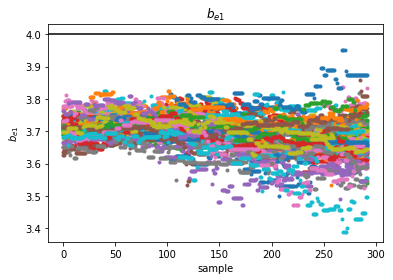

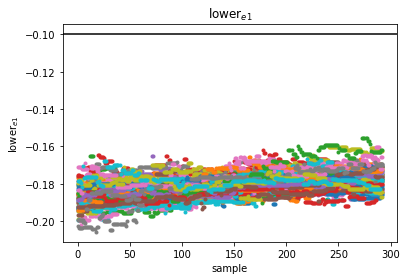

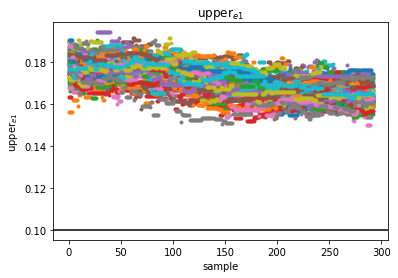

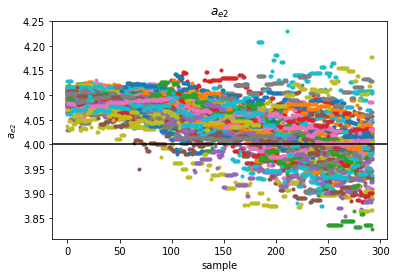

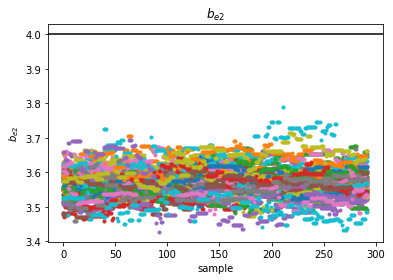

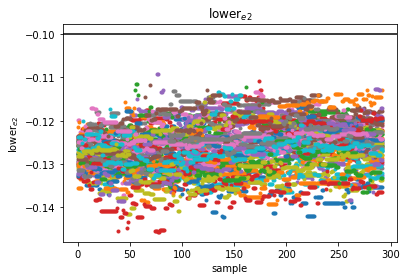

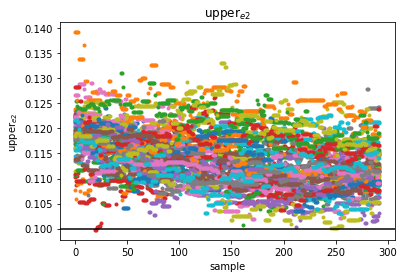

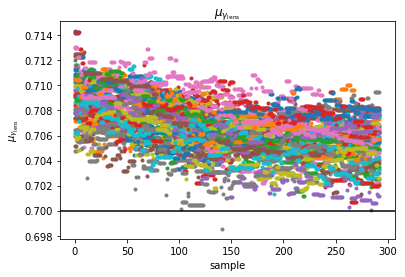

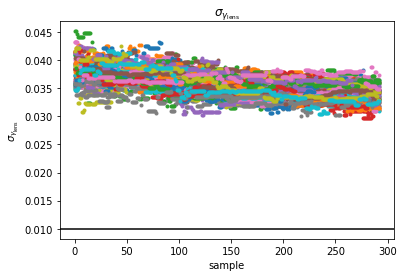

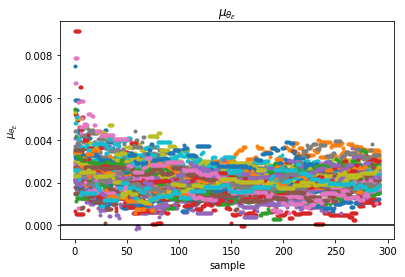

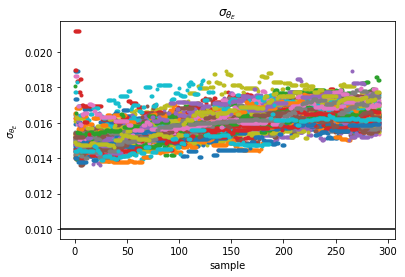

In [156]:
burnin = 1400
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

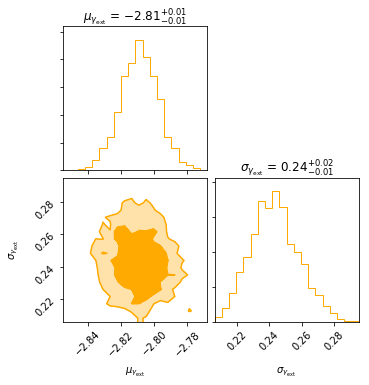

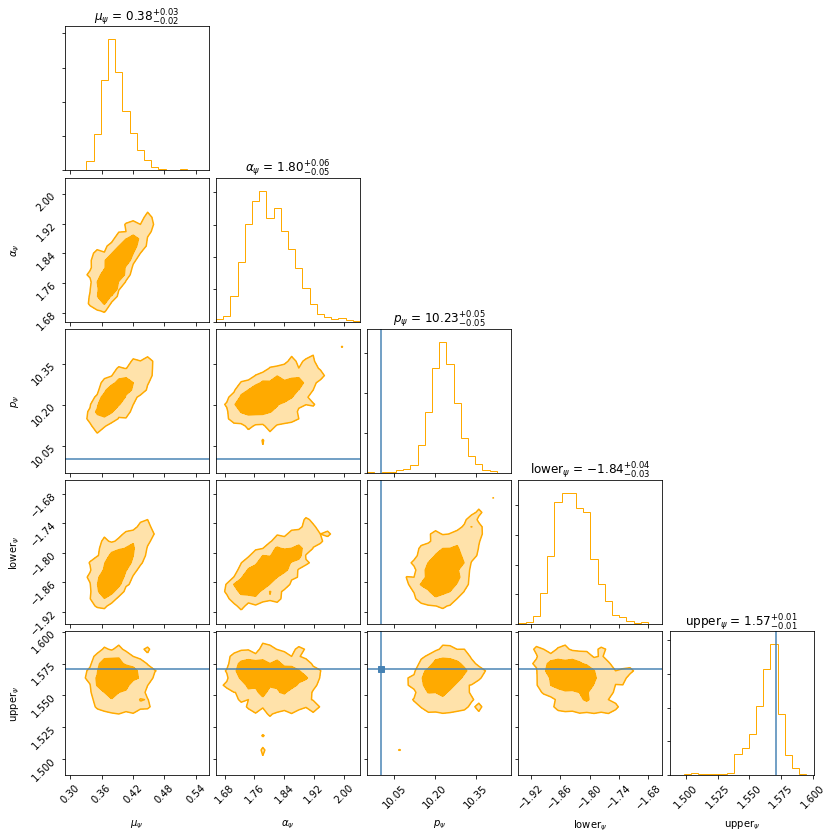

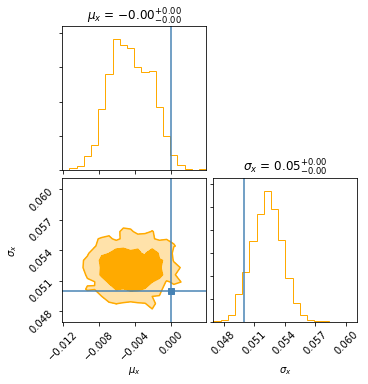

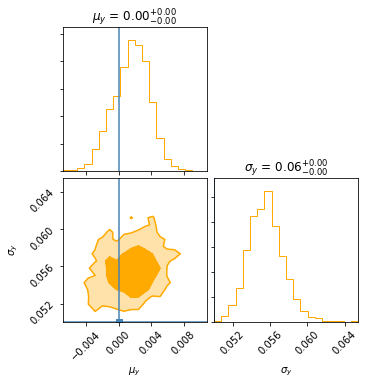

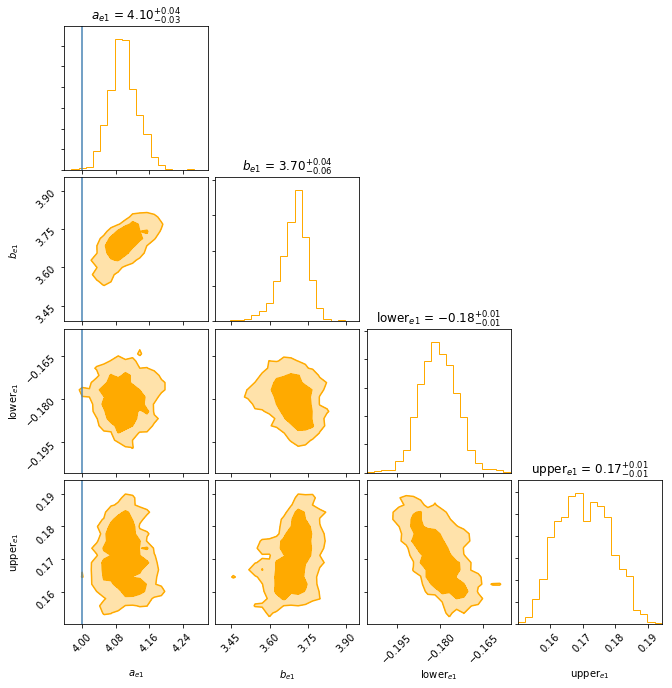

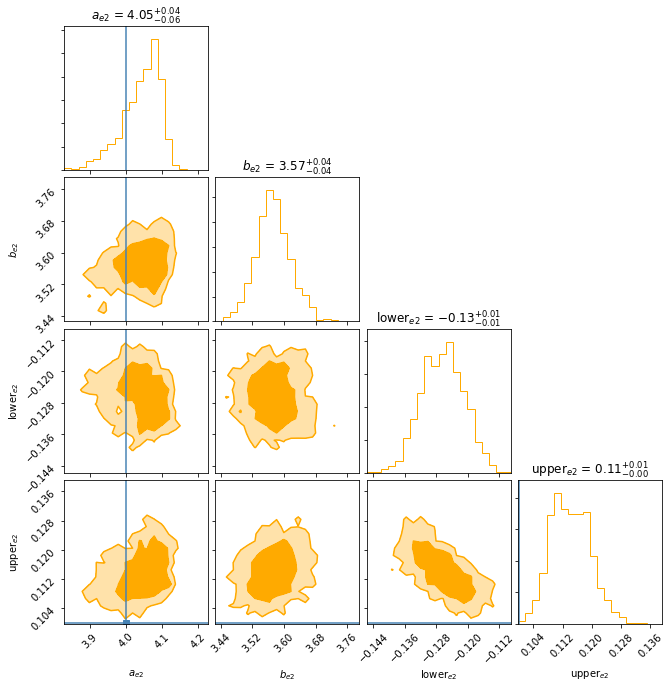

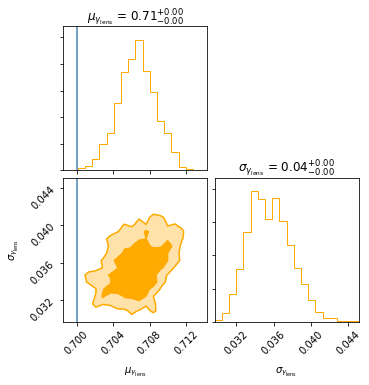

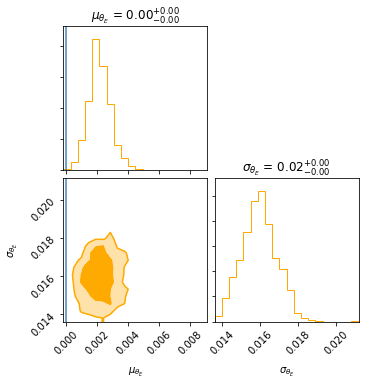

In [157]:
hier_infer.plot_corner(burnin,hyperparam_plot_names)

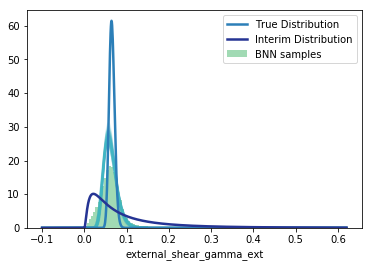

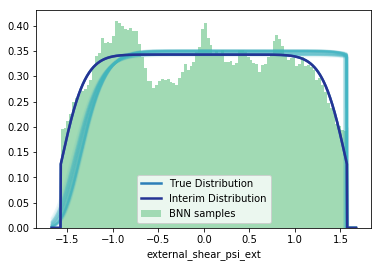

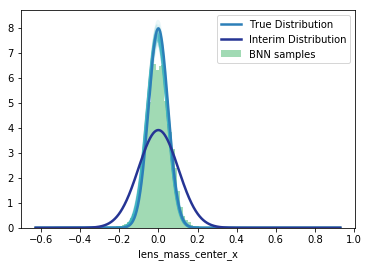

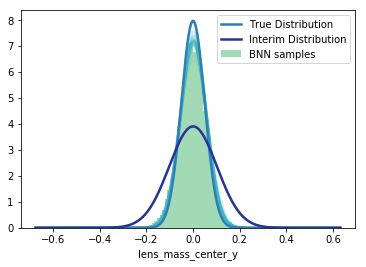

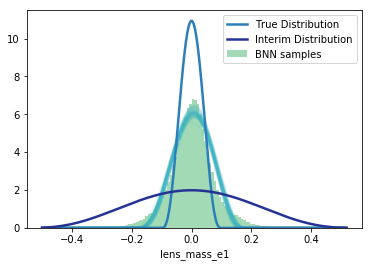

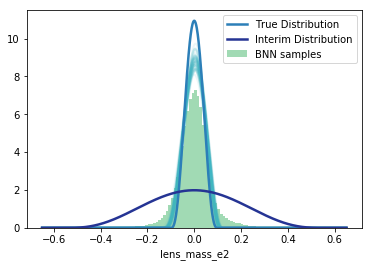

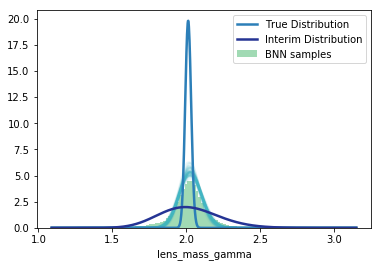

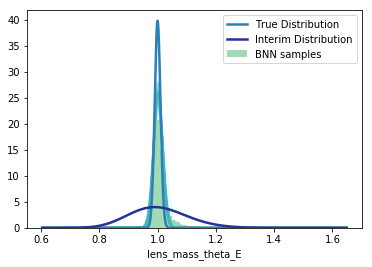

In [152]:
hier_infer.plot_distributions(burnin,hyperparam_plot_names)